# Fiddling with data from the General Election 2017

* Tweet data collected directly from Twitter REST API, using a method loosely based on <a href="https://www.karambelkar.info/2015/01/how-to-use-twitters-search-rest-api-most-effectively./">this tutorial</a> 

* Election result data tables from <a href="http://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-7979">this Parliament briefing</a> which were cleaned (just reformatting timestamp and removing commas from place names)

In [71]:
# Standard data analysis imports
import pandas as pd
from pandasql import sqldf
import datetime
from textwrap import wrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
import psycopg2 as pg
import pandas.io.sql as psqlg
import matplotlib.patches as mpatches

# Setting plots to use ggplot and some basic defaults for titles 
%matplotlib inline
plt.style.use('ggplot')
plt.rc('font', size=20) 
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=15)

In [74]:
# Read in the combined table
ge2017_df = pd.read_csv('data/hocl_ge2017_combined.csv')
ge2017_df.head(5)

,ons_id,ons_region_id,constituency_name,county_name,region_name,country_name,constituency_type,declaration_time,result,first_party,...,other,party_name,party_abbreviation,firstname,surname,gender,sitting_mp,former_mp,votes,share
0,N06000013,N92000002,North Down,Northern Ireland,Northern Ireland,Northern Ireland,County,09/06/2017 01:15,Ind hold,Ind,...,16185,Independent,Ind,Gavan,Reynolds,Male,No,No,16185,0.4130
1,W07000064,W92000004,Ceredigion,Dyfed,Wales,Wales,County,09/06/2017 06:24,PC gain from LD,PC,...,157,Plaid Cymru,PC,Ben,Lake,Male,No,No,11623,0.2923
2,N06000003,N92000002,Belfast South,Northern Ireland,Northern Ireland,Northern Ireland,Borough,09/06/2017 03:21,DUP gain from SDLP,DUP,...,0,Democratic Unionist Party,DUP,Emma,Little Pengelly,Female,No,No,13299,0.3043
3,S14000042,S92000003,Lanark and Hamilton East,Scotland,Scotland,Scotland,County,09/06/2017 03:01,SNP hold,SNP,...,0,Scottish National Party,SNP,Angela,Crawley,Female,Yes,Yes,16444,0.3258
4,S14000049,S92000003,North East Fife,Scotland,Scotland,Scotland,County,09/06/2017 06:33,SNP hold,SNP,...,224,Scottish National Party,SNP,Stephen,Gethins,Male,Yes,Yes,13743,0.3286


In [75]:
# View basic information using describe()
ge2017_df.describe()

,electorate,valid_votes,invalid_votes,majority,con,lab,ld,ukip,green,snp,pc,dup,sf,sdlp,uup,alliance,other,votes,share
count,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,72028.901690,49528.918587,114.089094,12016.370200,20948.741935,19781.672811,3643.411674,912.546851,811.388633,1501.640553,252.635945,471.975422,367.812596,147.187404,127.926267,104.749616,457.228879,27659.657450,0.556593
std,8481.834459,7409.599498,84.227502,8647.344144,9874.040086,9166.655625,4793.572343,994.894901,1467.164625,4851.281063,1350.190755,3007.354523,2690.525132,1230.726869,1229.500349,839.835138,2128.081989,6512.192502,0.093804
min,21301.000000,14818.000000,26.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6013.000000,0.292300
25%,67170.000000,44698.000000,79.000000,4483.500000,12703.000000,13810.500000,1077.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23270.000000,0.494050
50%,72486.000000,50191.000000,104.000000,11503.000000,21607.000000,18787.000000,1849.000000,838.000000,705.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27208.000000,0.555900
75%,77665.500000,54758.500000,136.000000,17486.000000,29331.500000,25324.000000,3927.500000,1579.000000,1103.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,324.500000,32316.000000,0.613550
max,110683.000000,74479.000000,1967.000000,42214.000000,42245.000000,47351.000000,34969.000000,10112.000000,30149.000000,21804.000000,16127.000000,28521.000000,27107.000000,18087.000000,24355.000000,15443.000000,39937.000000,47351.000000,0.857300


In [76]:
# Calculate the turnout percentage from the valid votes as a percentage of the electorate
ge2017_df['turnout'] = ge2017_df['valid_votes'] / ge2017_df['electorate']

In [77]:
# Getting various interesting mins and maxes based on the describe()

highest_turnout = ge2017_df[ge2017_df['turnout'] > 0.795]
lowest_turnout =  ge2017_df[ge2017_df['turnout'] < 0.531]

greatest_share =  ge2017_df[ge2017_df['share'] > 0.857]
lowest_winning_share = ge2017_df[ge2017_df['share'] < 0.293]

highest_majority = ge2017_df[ge2017_df['majority'] == 42214]
smallest_majority = ge2017_df[ge2017_df['majority'] == 2]

highest_invalid_votes = ge2017_df[ge2017_df['invalid_votes'] == 1967]

largest_electorate = ge2017_df[ge2017_df['electorate'] == 110683]
smallest_electorate = ge2017_df[ge2017_df['electorate'] == 21301]

print('\nhighest_turnout')
print(highest_turnout)
print('\nlowest_turnout')
print(lowest_turnout)
print('\ngreatest_share')
print(greatest_share)
print('\nlowest_winning_share')
print(lowest_winning_share)
print('\nhighest_majority')
print(highest_majority)
print('\nsmallest_majority')
print(smallest_majority)
print('\nhighest_invalid_votes')
print(highest_invalid_votes)
print('\nlargest_electorate')
print(largest_electorate)
print('\nsmallest_electorate')
print(smallest_electorate)


highest_turnout
        ons_id ons_region_id constituency_name county_name region_name  \
237  E14001005     E12000007        Twickenham      London      London   

    country_name constituency_type  declaration_time            result  \
237      England           Borough  09/06/2017 03:02  LD gain from Con   

    first_party    ...           party_name  party_abbreviation  firstname  \
237          LD    ...     Liberal Democrat                  LD      Vince   

     surname  gender  sitting_mp  former_mp  votes   share   turnout  
237    Cable    Male          No        Yes  34969  0.5275  0.795206  

[1 rows x 38 columns]

lowest_turnout
       ons_id ons_region_id   constituency_name county_name region_name  \
63  S14000032     S92000003  Glasgow North East    Scotland    Scotland   

   country_name constituency_type  declaration_time             result  \
63     Scotland           Borough  09/06/2017 03:01  Lab gain from SNP   

   first_party    ...                  party_na

In [78]:
# Selecting only the required data, and converting the declaration time to a proper datetime
ge2017_sel = ge2017_df[['constituency_name','first_party', 'declaration_time', 'turnout', 'share']]
ge2017_sel['declaration_time'] = pd.to_datetime(ge2017_sel['declaration_time'], dayfirst=True)
ge2017_sel.head(10)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,constituency_name,first_party,declaration_time,turnout,share
0,North Down,Ind,2017-06-09 01:15:00,0.609087,0.4130
1,Ceredigion,PC,2017-06-09 06:24:00,0.732870,0.2923
2,Belfast South,DUP,2017-06-09 03:21:00,0.661145,0.3043
3,Lanark and Hamilton East,SNP,2017-06-09 03:01:00,0.652801,0.3258
4,North East Fife,SNP,2017-06-09 06:33:00,0.712652,0.3286
5,Edinburgh North and Leith,SNP,2017-06-09 04:07:00,0.711588,0.3403
6,Edinburgh West,LD,2017-06-09 03:58:00,0.738392,0.3430
7,Dunfermline and West Fife,SNP,2017-06-09 02:58:00,0.674093,0.3552
8,Edinburgh South West,SNP,2017-06-09 04:20:00,0.693894,0.3558
9,Caithness Sutherland and Easter Ross,LD,2017-06-09 03:41:00,0.659320,0.3579


In [79]:
ge2017_sel.dtypes

constituency_name            object
first_party                  object
declaration_time     datetime64[ns]
turnout                     float64
share                       float64
dtype: object

In [80]:
# We only have tweet data up to 8am, so need to find which contituencies declared after that time
ge2017_sel[ge2017_sel['declaration_time'] > '2017-06-09 08:00:00']

,constituency_name,first_party,declaration_time,turnout,share
53,Kensington,Lab,2017-06-09 21:03:00,0.638361,0.4223
165,St Austell and Newquay,Con,2017-06-09 08:52:00,0.689641,0.4954
177,Wells,Con,2017-06-09 10:44:00,0.737929,0.5011
191,North Cornwall,Con,2017-06-09 09:54:00,0.739992,0.5071
306,Southend West,Con,2017-06-09 08:31:00,0.697297,0.5519
314,South East Cornwall,Con,2017-06-09 09:21:00,0.740456,0.5541


In [81]:
# Exclude these constituencies from the dataframe
ge2017_sel = ge2017_sel[ge2017_sel['declaration_time'] < '2017-06-09 08:00:00']
ge2017_sel.head(10)

,constituency_name,first_party,declaration_time,turnout,share
0,North Down,Ind,2017-06-09 01:15:00,0.609087,0.4130
1,Ceredigion,PC,2017-06-09 06:24:00,0.732870,0.2923
2,Belfast South,DUP,2017-06-09 03:21:00,0.661145,0.3043
3,Lanark and Hamilton East,SNP,2017-06-09 03:01:00,0.652801,0.3258
4,North East Fife,SNP,2017-06-09 06:33:00,0.712652,0.3286
5,Edinburgh North and Leith,SNP,2017-06-09 04:07:00,0.711588,0.3403
6,Edinburgh West,LD,2017-06-09 03:58:00,0.738392,0.3430
7,Dunfermline and West Fife,SNP,2017-06-09 02:58:00,0.674093,0.3552
8,Edinburgh South West,SNP,2017-06-09 04:20:00,0.693894,0.3558
9,Caithness Sutherland and Easter Ross,LD,2017-06-09 03:41:00,0.659320,0.3579


In [82]:
# Get the unique values of 'first_party' as an array
parties = ge2017_sel['first_party'].unique()
parties

array(['Ind', 'PC', 'DUP', 'SNP', 'LD', 'Lab', 'Con', 'SF', 'Green', 'Spk'], dtype=object)

In [83]:
# Then make a dict with an appropriate colour for each party
party_col_dict = dict([("Lab", "red"), ("Con", "blue"), ("LD", "orange"), ("SNP", "yellow"),
                      ("Green", "green"), ("Ind", "purple"), ("PC", "lime"), ("DUP", "maroon"), ("SF","teal"),
                      ("Spk","magenta")])
party_col_dict

{'Con': 'blue',
 'DUP': 'maroon',
 'Green': 'green',
 'Ind': 'purple',
 'LD': 'orange',
 'Lab': 'red',
 'PC': 'lime',
 'SF': 'teal',
 'SNP': 'yellow',
 'Spk': 'magenta'}

In [84]:
tweets_df = pd.read_csv('data/election_night_tweets_time_grouped.csv')
tweets_df['date_time'] = pd.to_datetime(tweets_df['date_time'], dayfirst=True)
tweets_df.head(10)

,date_time,subject,subject_count
0,2017-06-08 22:00:00,BBC Coverage,43
1,2017-06-08 22:00:00,Conservative Seats,25
2,2017-06-08 22:00:00,ITV Coverage,2
3,2017-06-08 22:00:00,Labour Seats,2
4,2017-06-08 22:00:00,SNP Seats,1
5,2017-06-08 22:00:00,"""coalitionofchaos"" OR #coalitionofchaos",1
6,2017-06-08 22:00:00,"""exit poll"" OR #exitpoll",856
7,2017-06-08 22:00:00,"""for the many"" OR #forthemany",15
8,2017-06-08 22:00:00,"""hung parliament"" OR #hungparliament",208
9,2017-06-08 22:00:00,"""strong and stable"" OR #strongandstable",39


In [85]:
# Get unique tweet subjects
tweet_subjects = tweets_df['subject'].unique()
tweet_subjects

array([' BBC Coverage', ' Conservative Seats', ' ITV Coverage',
       ' Labour Seats', ' SNP Seats',
       ' "coalitionofchaos" OR #coalitionofchaos',
       ' "exit poll" OR #exitpoll', ' "for the many" OR #forthemany',
       ' "hung parliament" OR #hungparliament',
       ' "strong and stable" OR #strongandstable', ' Lib Dem Seats'], dtype=object)

In [16]:
index = [0, 2, 5, 6, 7, 8, 9]
party_subjects = np.delete(tweet_subjects, index)
party_subjects

array([' Conservative Seats', ' Labour Seats', ' SNP Seats',
       ' Lib Dem Seats'], dtype=object)

In [88]:
tweet_subj_col_dict = dict([(" Labour Seats", "red"), (" Conservative Seats", "blue"), (" Lib Dem Seats", "orange"), (" SNP Seats", "yellow"),
                      (" \"exit poll\" OR #exitpoll", "magenta"), (" \"hung parliament\" OR #hungparliament", "cyan")])
tweet_subj_col_dict

{' "exit poll" OR #exitpoll': 'magenta',
 ' "hung parliament" OR #hungparliament': 'cyan',
 ' Conservative Seats': 'blue',
 ' Labour Seats': 'red',
 ' Lib Dem Seats': 'orange',
 ' SNP Seats': 'yellow'}

In [89]:
index = [0, 1, 2, 3, 4, 5, 7, 9, 10]
non_party_subjects = np.delete(tweet_subjects, index)
non_party_subjects

array([' "exit poll" OR #exitpoll', ' "hung parliament" OR #hungparliament'], dtype=object)

In [90]:
ge2017_sel.describe()

,turnout,share
count,645.000000,645.000000
mean,0.686210,0.557070
std,0.049820,0.094013
min,0.530193,0.292300
25%,0.652739,0.493900
50%,0.690087,0.559400
75%,0.723591,0.613800
max,0.795206,0.857300


In [97]:
# Build a dict of 'interesting' seats to annotate on the plot
key_moments = {}

key_moments['sheffield_hallam'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Sheffield Hallam']['declaration_time']).at[22, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Sheffield Hallam']['share']).at[22, 'share'],
     "Nick Clegg (Liberal Democrats)\nloses Sheffield Hallam"])

key_moments['newcastle'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Newcastle Upon Tyne Central']['declaration_time']).at[565, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Newcastle Upon Tyne Central']['share']).at[565, 'share'],
     "Newcastle Upon Tyne Central declares first,\nbeating Houghton and Sunderland South\nfor the first time since 1992"])

key_moments['hackney'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Hackney North and Stoke Newington']['declaration_time']).at[629, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Hackney North and Stoke Newington']['share']).at[629, 'share'],
     "Diane Abbott (Labour) increases majority in\nHackney North & Stoke Newington"])

key_moments['gordon'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Gordon']['declaration_time']).at[43, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Gordon']['share']).at[43, 'share'],
     "Alex Salmond (SNP) loses Gordon"])

key_moments['islington'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Islington North']['declaration_time']).at[625, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Islington North']['share']).at[625, 'share'],
     "Jeremy Corbyn wins Islington North"])

key_moments['maidenhead'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Maidenhead']['declaration_time']).at[564, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Maidenhead']['share']).at[564, 'share'],
     "Prime Minister Theresa May wins Maidenhead\n(defeating Lord Buckethead)"])

key_moments['twickenham'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Twickenham']['declaration_time']).at[237, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Twickenham']['share']).at[237, 'share'],
     "Vince Cable returns to Parliament\nfor Twickenham, which also has\nthe highest turnout (79.52%)"])
    
key_moments['glasgow_ne'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Glasgow North East']['declaration_time']).at[63, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Glasgow North East']['share']).at[63, 'share'],
     "Lowest turnout\nGlasgow North East (53.019%)"])
    
key_moments['liv_walton'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Liverpool Walton']['declaration_time']).at[650, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Liverpool Walton']['share']).at[650, 'share'],
     "Largest vote share\nLiverpool Walton (Labour - 85.73%)"])

key_moments['ceredigion'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Ceredigion']['declaration_time']).at[1, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Ceredigion']['share']).at[1, 'share'],
     "Smallest (winning) vote share\nCeredigion (29.23%)"])
    
key_moments['knowsley'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Knowsley']['declaration_time']).at[649, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Knowsley']['share']).at[649, 'share'],
     "Largest vote majority\nKnowsley (Labour - 42214)"])

key_moments['ne_fife'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'North East Fife']['declaration_time']).at[4, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'North East Fife']['share']).at[4, 'share'],
     "Smallest vote majority\nNorth East Fife (SNP - 2)"])
    
key_moments['bucks'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Buckingham']['declaration_time']).at[568, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Buckingham']['share']).at[568, 'share'],
     "The Speaker John Bercow\nwins Buckingham, which also has\nhighest number of invalid votes"])
    
key_moments['iow'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Isle Of Wight']['declaration_time']).at[203, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Isle Of Wight']['share']).at[203, 'share'],
     "Largest constituency\nIsle of Wight"])

key_moments['eileanan'] = \
    ([pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Na h-Eileanan An Iar']['declaration_time']).at[40, 'declaration_time'],
    pd.DataFrame(ge2017_sel[ge2017_sel['constituency_name'] == 'Na h-Eileanan An Iar']['share']).at[40, 'share'],
     "Smallest constituency\nNa h-Eileanan An Iar"])
    
key_moments

{'bucks': [Timestamp('2017-06-09 04:52:00'),
  0.65110000000000001,
  'The Speaker John Bercow\nwins Buckingham, which also has\nhighest number of invalid votes'],
 'ceredigion': [Timestamp('2017-06-09 06:24:00'),
  0.2923,
  'Smallest (winning) vote share\nCeredigion (29.23%)'],
 'eileanan': [Timestamp('2017-06-09 02:16:00'),
  0.40579999999999999,
  'Smallest constituency\nNa h-Eileanan An Iar'],
 'glasgow_ne': [Timestamp('2017-06-09 03:01:00'),
  0.42920000000000003,
  'Lowest turnout\nGlasgow North East (53.019%)'],
 'gordon': [Timestamp('2017-06-09 04:24:00'),
  0.40720000000000001,
  'Alex Salmond (SNP) loses Gordon'],
 'hackney': [Timestamp('2017-06-09 03:24:00'),
  0.75070000000000003,
  'Diane Abbott (Labour) increases majority in\nHackney North & Stoke Newington'],
 'iow': [Timestamp('2017-06-09 03:36:00'),
  0.51280000000000003,
  'Largest constituency\nIsle of Wight'],
 'islington': [Timestamp('2017-06-09 03:16:00'),
  0.7298,
  'Jeremy Corbyn wins Islington North'],
 'know

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736489.052083, right=736489.052083
  'left=%s, right=%s') % (left, right))


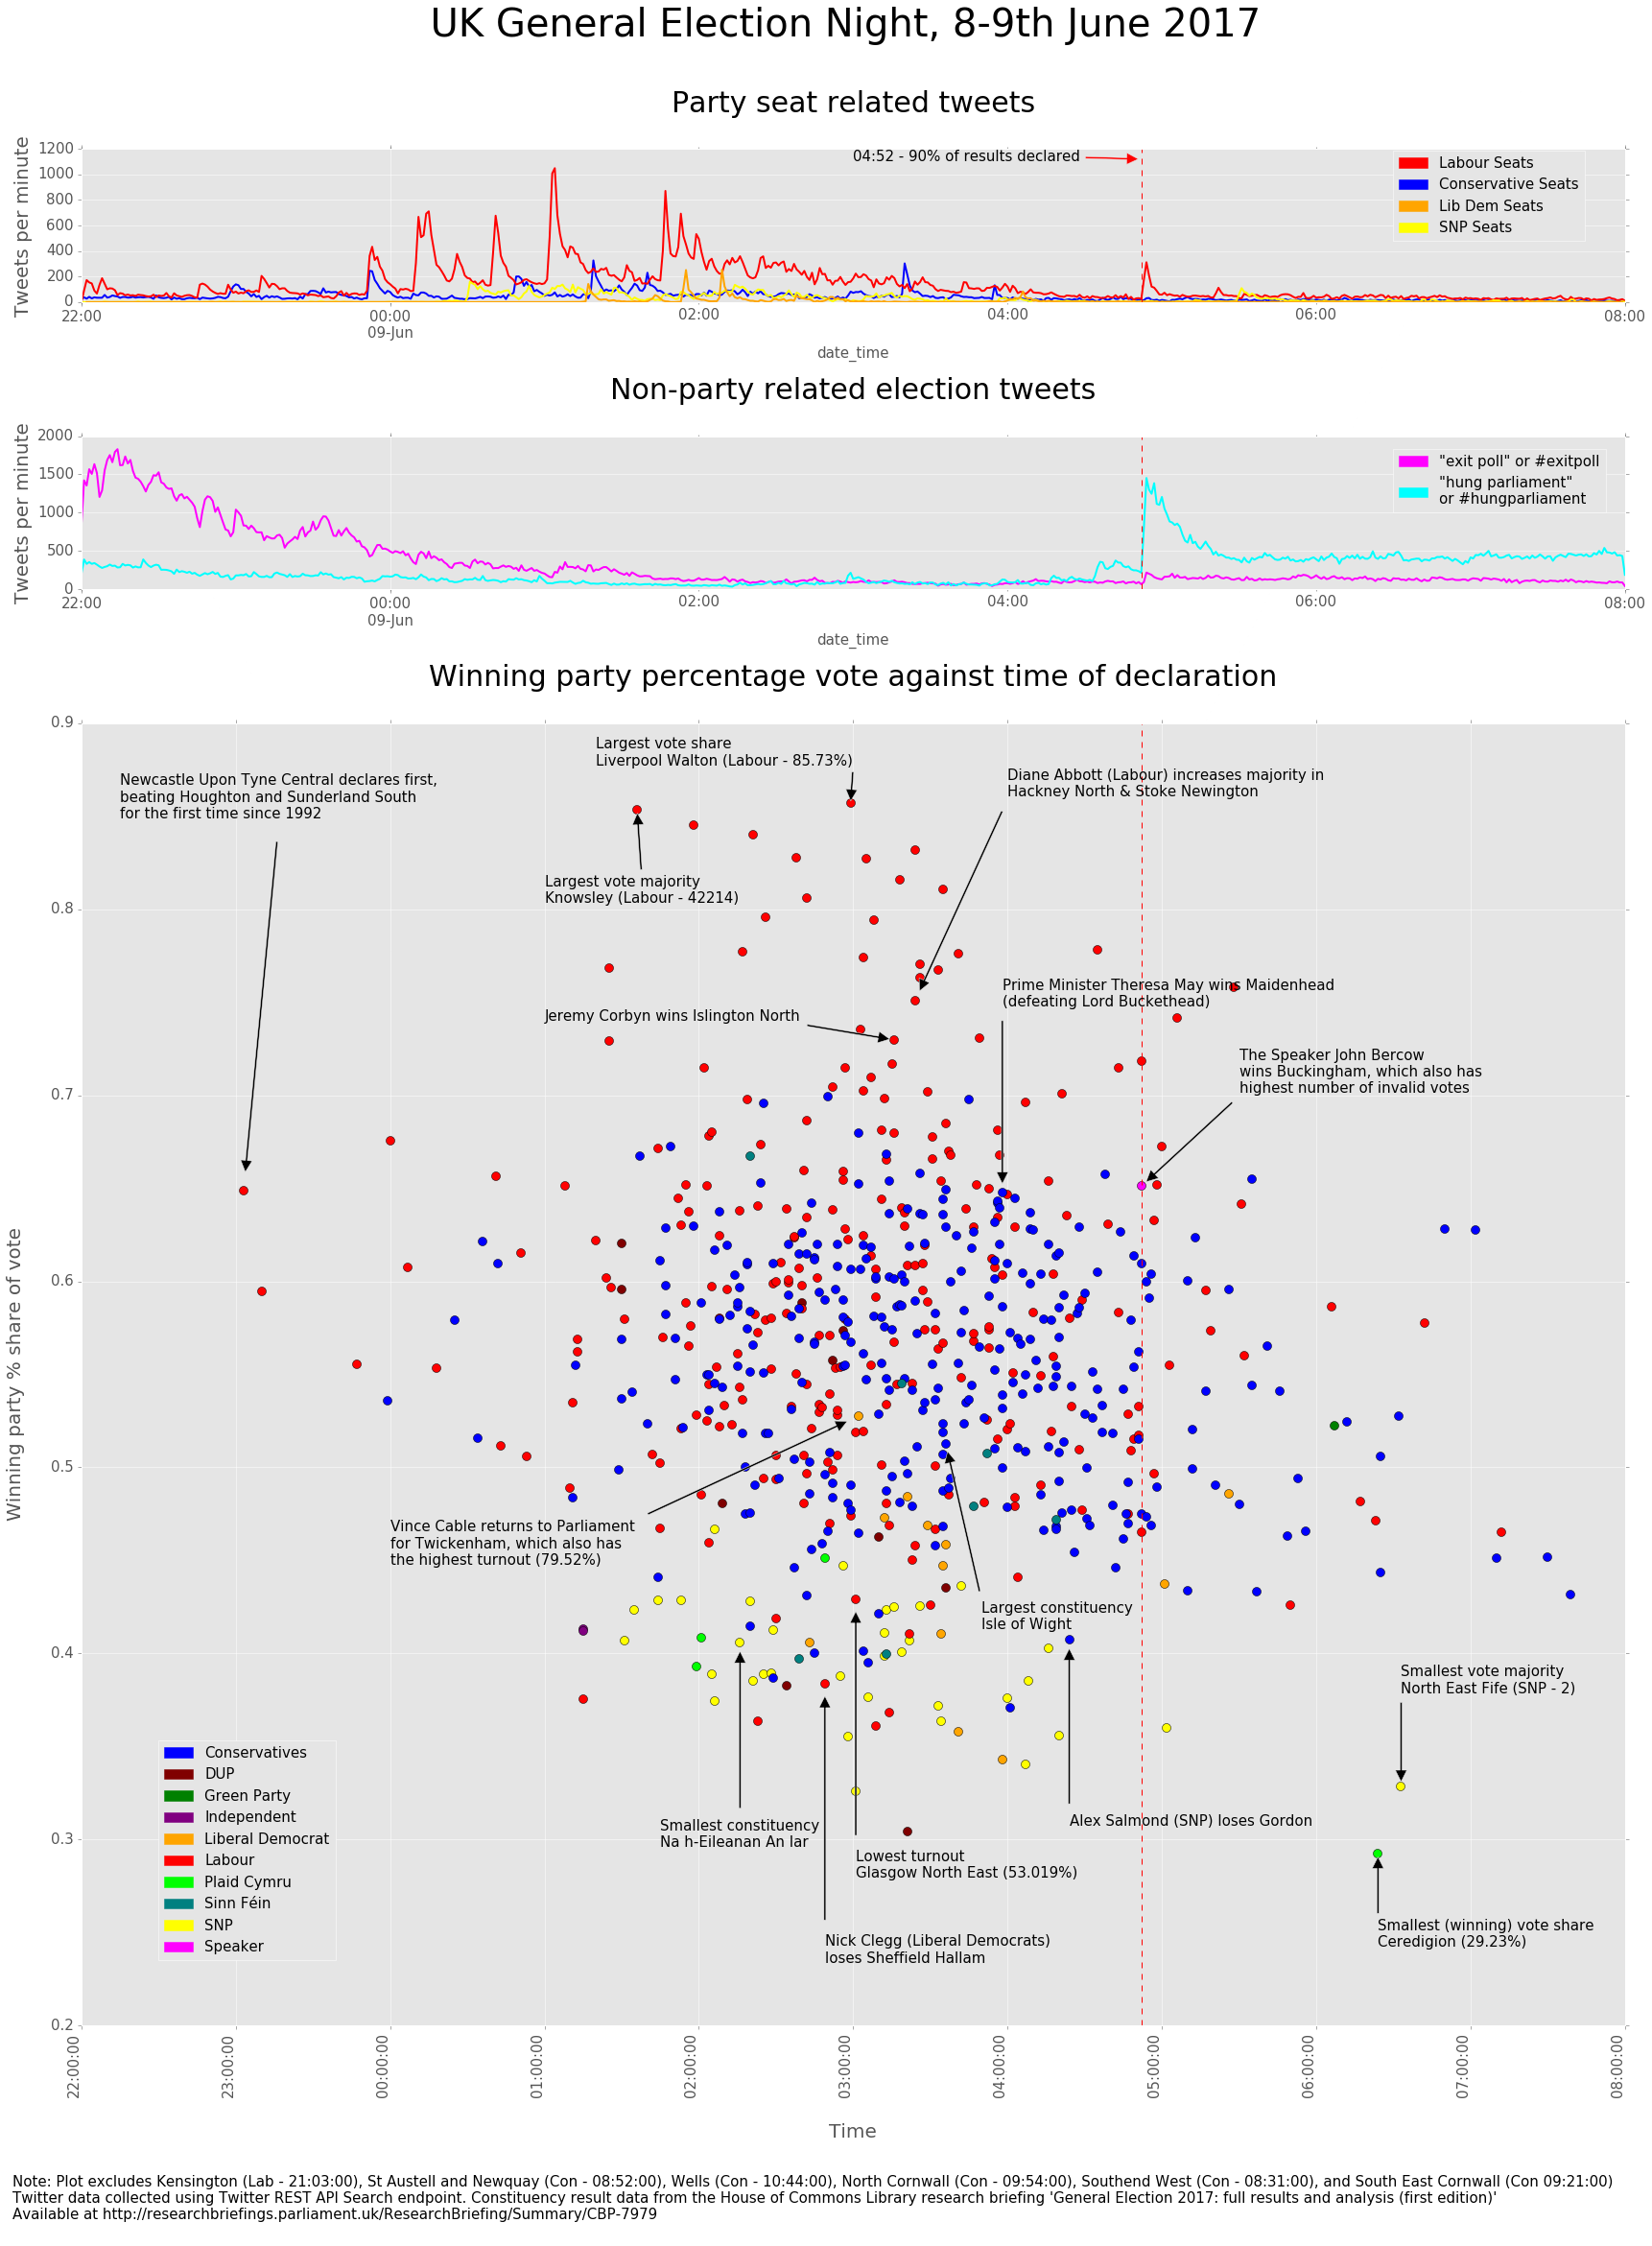

In [98]:
# Great monstrosity of a script to make the plot - The code for the annotations especially could certainly be optimised, but I haven't yet 
# come up with a way to automatically set where they should be

fig = plt.figure(figsize=(24, 30))

subp_axes = plt.subplot2grid((7, 1), (0, 0))
for i in range (len(party_subjects)):
    tweets_for_sub = pd.DataFrame(tweets_df[tweets_df['subject'] == party_subjects[i]]) 
    tweets_for_sub[['date_time', 'subject_count']].plot(ax=subp_axes, x='date_time', y='subject_count', 
                                                        linewidth=2, color=tweet_subj_col_dict[party_subjects[i]])

legendpatch_list1 = ([mpatches.Patch(color='red', label='Labour Seats')]+
                    [mpatches.Patch(color='blue', label='Conservative Seats')]+
                    [mpatches.Patch(color='orange', label='Lib Dem Seats')]+
                    [mpatches.Patch(color='yellow', label='SNP Seats')])   
plt.legend(handles=legendpatch_list1, loc=(0.85, 0.4))

plt.axvline('2017-06-09 04:52:00', color='red', linestyle='--')
plt.annotate("04:52 - 90% of results declared", xy=('2017-06-09 04:52:00', 1120), xytext=('2017-06-09 03:00:00', 1100), 
             arrowprops=dict(facecolor='red', shrink=0.05, width=2), size=15)

plt.title("Party seat related tweets\n", size=30)
plt.ylabel('Tweets per minute', fontsize=20)

subn_axes = plt.subplot2grid((7, 1), (1, 0))
for i in range (len(non_party_subjects)):
    tweets_for_sub = pd.DataFrame(tweets_df[tweets_df['subject'] == non_party_subjects[i]])    
    tweets_for_sub[['date_time', 'subject_count']].plot(ax=subn_axes, x='date_time', y='subject_count', 
                                                        linewidth=2, color=tweet_subj_col_dict[non_party_subjects[i]])
    
legendpatch_list2 = ([mpatches.Patch(color='magenta', label='\"exit poll" or #exitpoll')]+
                    [mpatches.Patch(color='cyan', label='\"hung parliament" \nor #hungparliament')])   
plt.legend(handles=legendpatch_list2, loc=(0.85, 0.5))
plt.axvline('2017-06-09 04:52:00', color='red', linestyle='--')
plt.title("Non-party related election tweets\n", size=30)
plt.ylabel('Tweets per minute', fontsize=20)

party_axes = plt.subplot2grid((7, 1), (2, 0), rowspan=5)
for i in range (len(parties)):
    ge2017_sel_party = pd.DataFrame(ge2017_sel[ge2017_sel['first_party'] == parties[i]])
    ge2017_sel_party[['declaration_time', 'share']].plot(ax=party_axes, x='declaration_time', y='share',
                                                   style='o', markersize=9, markerfacecolor=party_col_dict[parties[i]])

party_axes.set_xlim(['2017-06-08 22:00:00', '2017-06-09 08:00:00'])
plt.xticks(rotation='vertical')

# creating a custom legend using mpatches
legendpatch_list3 = ([mpatches.Patch(color='blue', label='Conservatives')]+
                    [mpatches.Patch(color='maroon', label='DUP')]+
                    [mpatches.Patch(color='green', label='Green Party')]+
                    [mpatches.Patch(color='purple', label='Independent')]+
                    [mpatches.Patch(color='orange', label='Liberal Democrat')]+
                    [mpatches.Patch(color='red', label='Labour')]+
                    [mpatches.Patch(color='lime', label='Plaid Cymru')]+
                    [mpatches.Patch(color='teal', label='Sinn Féin')]+
                    [mpatches.Patch(color='yellow', label='SNP')]+
                    [mpatches.Patch(color='magenta', label='Speaker')])   
plt.legend(handles=legendpatch_list3, loc=(0.05, 0.05))
plt.ylabel('Winning party % share of vote\n', fontsize=20)
plt.xlabel('\nTime', fontsize=20)

plt.annotate(key_moments['sheffield_hallam'][2], xy=(key_moments['sheffield_hallam'][0], key_moments['sheffield_hallam'][1]), 
             xytext=(key_moments['sheffield_hallam'][0], key_moments['sheffield_hallam'][1] - 0.15), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['newcastle'][2], xy=(key_moments['newcastle'][0], key_moments['newcastle'][1]), 
             xytext=('2017-06-08 22:15:00', key_moments['newcastle'][1] + 0.20), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['hackney'][2], xy=(key_moments['hackney'][0], key_moments['hackney'][1]), 
             xytext=('2017-06-09 04:00:00', key_moments['hackney'][1] + 0.11), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['maidenhead'][2], xy=(key_moments['maidenhead'][0], key_moments['maidenhead'][1]), 
             xytext=(key_moments['maidenhead'][0], key_moments['maidenhead'][1] + 0.1), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['islington'][2], xy=(key_moments['islington'][0], key_moments['islington'][1]), 
             xytext=('2017-06-09 01:00:00', key_moments['islington'][1] + 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['bucks'][2], xy=(key_moments['bucks'][0], key_moments['bucks'][1]), 
             xytext=('2017-06-09 05:30:00', key_moments['bucks'][1] + 0.05), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['ceredigion'][2], xy=(key_moments['ceredigion'][0], key_moments['ceredigion'][1]), 
             xytext=(key_moments['ceredigion'][0], key_moments['ceredigion'][1] - 0.05), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['eileanan'][2], xy=(key_moments['eileanan'][0], key_moments['eileanan'][1]), 
             xytext=('2017-06-09 01:45:00', key_moments['eileanan'][1] - 0.11), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['glasgow_ne'][2], xy=(key_moments['glasgow_ne'][0], key_moments['glasgow_ne'][1]), 
             xytext=(key_moments['glasgow_ne'][0], key_moments['glasgow_ne'][1] - 0.15), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['gordon'][2], xy=(key_moments['gordon'][0], key_moments['gordon'][1]), 
             xytext=(key_moments['gordon'][0], key_moments['gordon'][1] - 0.10), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['iow'][2], xy=(key_moments['iow'][0], key_moments['iow'][1]), 
             xytext=('2017-06-09 03:50:00', key_moments['iow'][1] - 0.1), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['knowsley'][2], xy=(key_moments['knowsley'][0], key_moments['knowsley'][1]), 
             xytext=('2017-06-09 01:00:00', key_moments['knowsley'][1] - 0.05), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['liv_walton'][2], xy=(key_moments['liv_walton'][0], key_moments['liv_walton'][1]), 
             xytext=('2017-06-09 01:20:00', key_moments['liv_walton'][1] + 0.02), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['twickenham'][2], xy=(key_moments['twickenham'][0], key_moments['twickenham'][1]), 
             xytext=('2017-06-09 00:00:00', key_moments['twickenham'][1] - 0.08), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.annotate(key_moments['ne_fife'][2], xy=(key_moments['ne_fife'][0], key_moments['ne_fife'][1]), 
             xytext=(key_moments['ne_fife'][0], key_moments['ne_fife'][1] + 0.05), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=2), size=15)

plt.axvline('2017-06-09 04:52:00', color='red', linestyle='--')
plt.title("Winning party percentage vote against time of declaration\n", size=30)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


label_string = '                      UK General Election Night, 8-9th June 2017\n'
plt.gcf().text(0.1, 1, label_string, fontsize=40)

source_string = 'Note: Plot excludes Kensington (Lab - 21:03:00), St Austell and Newquay (Con - 08:52:00), Wells (Con - 10:44:00), North Cornwall (Con - 09:54:00), Southend West (Con - 08:31:00), and South East Cornwall (Con 09:21:00)'
source_string = source_string + '\nTwitter data collected using Twitter REST API Search endpoint. Constituency result data from the House of Commons Library research briefing \'General Election 2017: full results and analysis (first edition)\''
source_string = source_string + '\nAvailable at http://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-7979\n'
plt.gcf().text(0.01, -0.04, source_string, fontsize=15)

plt.show()

# Finally, save this figure
plt.savefig('vis_output/ElectionDeclarationTimeAndVoteShare.png')